In [1]:
# Librerías

import warnings
warnings.filterwarnings('ignore')
from ucimlrepo import fetch_ucirepo
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor

In [2]:
class DataFeaturesImportances:
    def __init__(self, x: pd.DataFrame, y: pd.Series, seed: int = 42):
        self.x = x
        self.y = y
        self.seed = seed
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            x, y, test_size=0.2, random_state=seed
        )

    def get_matrix_corr(self) -> pd.DataFrame:
        df = self.x.copy()
        df['target'] = self.y
        corr_matrix = df.corr()
        return corr_matrix['target']

    # RandomForestRegressor
    def get_random_forest_regressor_feature_importance(self) -> pd.DataFrame:
        X = self.x.copy()
        X_train = self.X_train.copy()
        y_train = self.y_train.copy()
        seed = self.seed
        # Entrenar el modelo
        reg = RandomForestRegressor(n_estimators=100, random_state=seed)
        reg.fit(X_train, y_train)
        # Calcular la importancia de las características
        importances = reg.feature_importances_
        feature_names = X.columns

        # Crear un DataFrame de la importancia de las características
        feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
        feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
        return feature_importance_df

    # RandomForestRegressor with Permutation
    def get_random_forest_regressor_permutation_feature_importance(self) -> pd.DataFrame:
        X = self.x.copy()
        X_train = self.X_train.copy()
        X_test = self.X_test.copy()
        y_train = self.y_train.copy()
        y_test = self.y_test.copy()
        seed = self.seed
        reg = RandomForestRegressor(n_estimators=100, random_state=seed)
        reg.fit(X_train, y_train)
        # Calcular la importancia de las características basada en permutación
        result = permutation_importance(reg, X_test, y_test, n_repeats=10, random_state=seed)

        # Crear un DataFrame de la importancia de las características
        importances = result.importances_mean
        feature_names = X.columns
        feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
        feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
        return feature_importance_df

    def get_lasso_linear_regression_feature_importance(self) -> pd.DataFrame:
        # Normalizar los datos
        X = self.x.copy()
        y = self.y.copy()
        seed = self.seed
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

        # Crear el modelo Lasso con validación cruzada
        lasso_cv = LassoCV(alphas=np.logspace(-4, 4, 100), cv=5)
        # Ajustar el modelo
        lasso_cv.fit(X_train, y_train)

        # Entrenar el modelo Lasso
        lasso = Lasso(alpha=lasso_cv.alpha_)
        lasso.fit(X_train, y_train)

        # Obtener los coeficientes del modelo
        importances = lasso.coef_
        feature_names = X.columns

        # Crear un DataFrame de la importancia de las características
        feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
        feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
        return feature_importance_df

    def get_xgboost_feature_importance(self):
        X = self.x.copy()
        X_train = self.X_train.copy()
        y_train = self.y_train.copy()
        seed = self.seed
        # Entrenar el modelo XGBoost
        # xgb = XGBRegressor(random_state=seed)
        xgb = XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1)
        xgb.fit(X_train, y_train)

        # Obtener la importancia de las características
        importances = xgb.feature_importances_
        feature_names = X.columns

        # Crear un DataFrame de la importancia de las características
        feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
        feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
        return feature_importance_df

    def get_feature_importance_matrix(self) -> pd.DataFrame:
        rf_importance = self.get_random_forest_regressor_feature_importance()
        rf_permutation_importance = self.get_random_forest_regressor_permutation_feature_importance()
        lasso_importance = self.get_lasso_linear_regression_feature_importance()
        xgboost_importance = self.get_xgboost_feature_importance()

        importance_matrix = pd.DataFrame({
            'Feature': self.x.columns,
            'Random Forest': rf_importance.set_index('Feature').reindex(self.x.columns)['Importance'].values,
            'RF Permutation': rf_permutation_importance.set_index('Feature').reindex(self.x.columns)['Importance'].values,
            'Lasso': lasso_importance.set_index('Feature').reindex(self.x.columns)['Importance'].values,
            'XGBoost': xgboost_importance.set_index('Feature').reindex(self.x.columns)['Importance'].values,
        })
        return importance_matrix


In [3]:
df = pd.read_csv('Steel_industry_data.csv')

In [4]:
# steel_industry_energy_consumption = fetch_ucirepo(id=851)
# print(steel_industry_energy_consumption.metadata) 
# dataset_filename = Path('./steel_industry_energy_consumption.parquet')
# if dataset_filename.exists():
#     df = pd.read_parquet(dataset_filename)
# else:
#     # fetch dataset
#     steel_industry_energy_consumption = fetch_ucirepo(id=851)
#     df = pd.DataFrame(steel_industry_energy_consumption.data.original)
#     df.to_parquet('steel_industry_energy_consumption.parquet')

In [5]:
df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y %H:%M')

In [6]:
# Hacemos una diferenciación entre fines de semana y días hábiles
# df['IsWeekend'] = df['WeekStatus'] == 'Weekend'
# df.drop(['WeekStatus'], axis=1, inplace=True)

In [7]:
df.head(n=5)

,date,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type
0,2018-01-01 00:15:00,3.17,2.95,0.0,0.0,73.21,100.0,900,Weekday,Monday,Light_Load
1,2018-01-01 00:30:00,4.00,4.46,0.0,0.0,66.77,100.0,1800,Weekday,Monday,Light_Load
2,2018-01-01 00:45:00,3.24,3.28,0.0,0.0,70.28,100.0,2700,Weekday,Monday,Light_Load
3,2018-01-01 01:00:00,3.31,3.56,0.0,0.0,68.09,100.0,3600,Weekday,Monday,Light_Load
4,2018-01-01 01:15:00,3.82,4.50,0.0,0.0,64.72,100.0,4500,Weekday,Monday,Light_Load


In [8]:
varianzas = df[['Usage_kWh', 'CO2(tCO2)', 'Lagging_Current_Reactive.Power_kVarh', 'Leading_Current_Reactive_Power_kVarh','Lagging_Current_Power_Factor', 'Leading_Current_Power_Factor', 'NSM']].var()
varianzas

Usage_kWh                               1.118527e+03
CO2(tCO2)                               2.608490e-04
Lagging_Current_Reactive.Power_kVarh    2.658856e+02
Leading_Current_Reactive_Power_kVarh    5.512265e+01
Lagging_Current_Power_Factor            3.580164e+02
Leading_Current_Power_Factor            9.276005e+02
NSM                                     6.220303e+08
dtype: float64

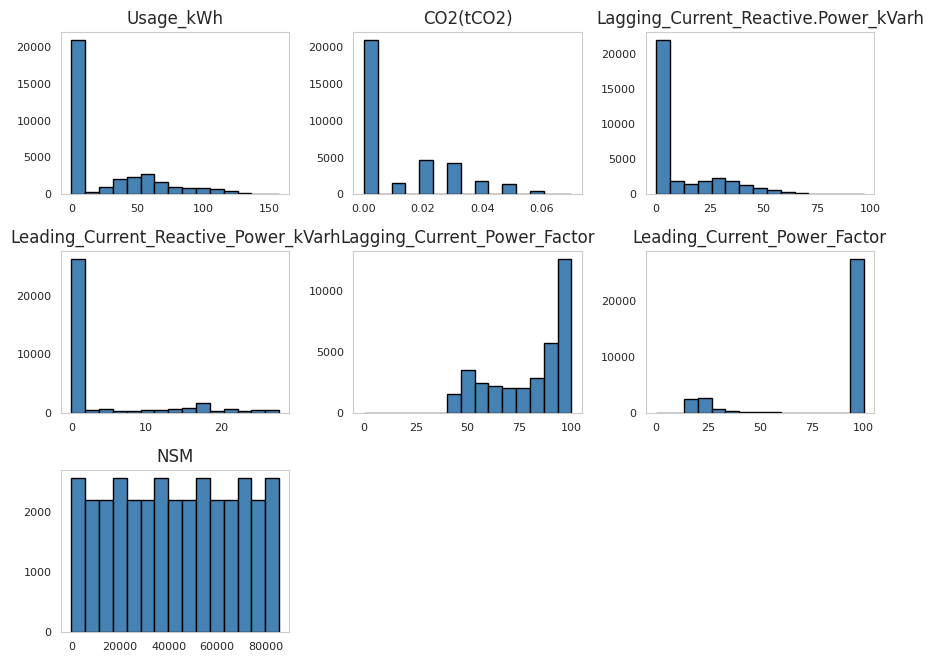

In [9]:
df[['Usage_kWh', 'CO2(tCO2)', 'Lagging_Current_Reactive.Power_kVarh', 'Leading_Current_Reactive_Power_kVarh','Lagging_Current_Power_Factor', 'Leading_Current_Power_Factor', 'NSM']].hist(bins=15, color='steelblue', edgecolor='black', linewidth=1.0,
           xlabelsize=8, ylabelsize=8, grid=False)

# command to give space b/t diff. plots 
plt.tight_layout(rect=(0, 0, 1.4, 1.4))   

In [10]:
# Utilizamos One Hot Enconder eliminando las columnas iniciales
df = pd.get_dummies(df, columns=["Day_of_week", "Load_Type", "WeekStatus"], drop_first=False)

In [11]:
# Crear nuevas columnas descomponiendo la fecha y hora en sus componentes
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['hour'] = df['date'].dt.hour
df['minute'] = df['date'].dt.minute
df['second'] = df['date'].dt.second
df['dayofweek'] = df['date'].dt.dayofweek  # Lunes=0, Domingo=6
df['dayofyear'] = df['date'].dt.dayofyear
df['weekofyear'] = df['date'].dt.isocalendar().week
df['quarter'] = df['date'].dt.quarter
df.drop(['date'], axis=1, inplace=True)

In [12]:
df.var()

Usage_kWh                                    1118.526534
Lagging_Current_Reactive.Power_kVarh          265.885635
Leading_Current_Reactive_Power_kVarh           55.122647
CO2(tCO2)                                       0.000261
Lagging_Current_Power_Factor                  358.016436
Leading_Current_Power_Factor                  927.600534
NSM                                     622030252.004909
Day_of_week_Friday                              0.122173
Day_of_week_Monday                              0.124124
Day_of_week_Saturday                            0.122173
Day_of_week_Sunday                              0.122173
Day_of_week_Thursday                            0.122173
Day_of_week_Tuesday                             0.122173
Day_of_week_Wednesday                           0.122173
Load_Type_Light_Load                            0.249759
Load_Type_Maximum_Load                          0.164468
Load_Type_Medium_Load                           0.200148
WeekStatus_Weekday             

In [13]:
# df.columns.to_list()

In [14]:
df.drop(["year", "second"], axis=1, inplace=True) # No tienen variabilidad

<Axes: >

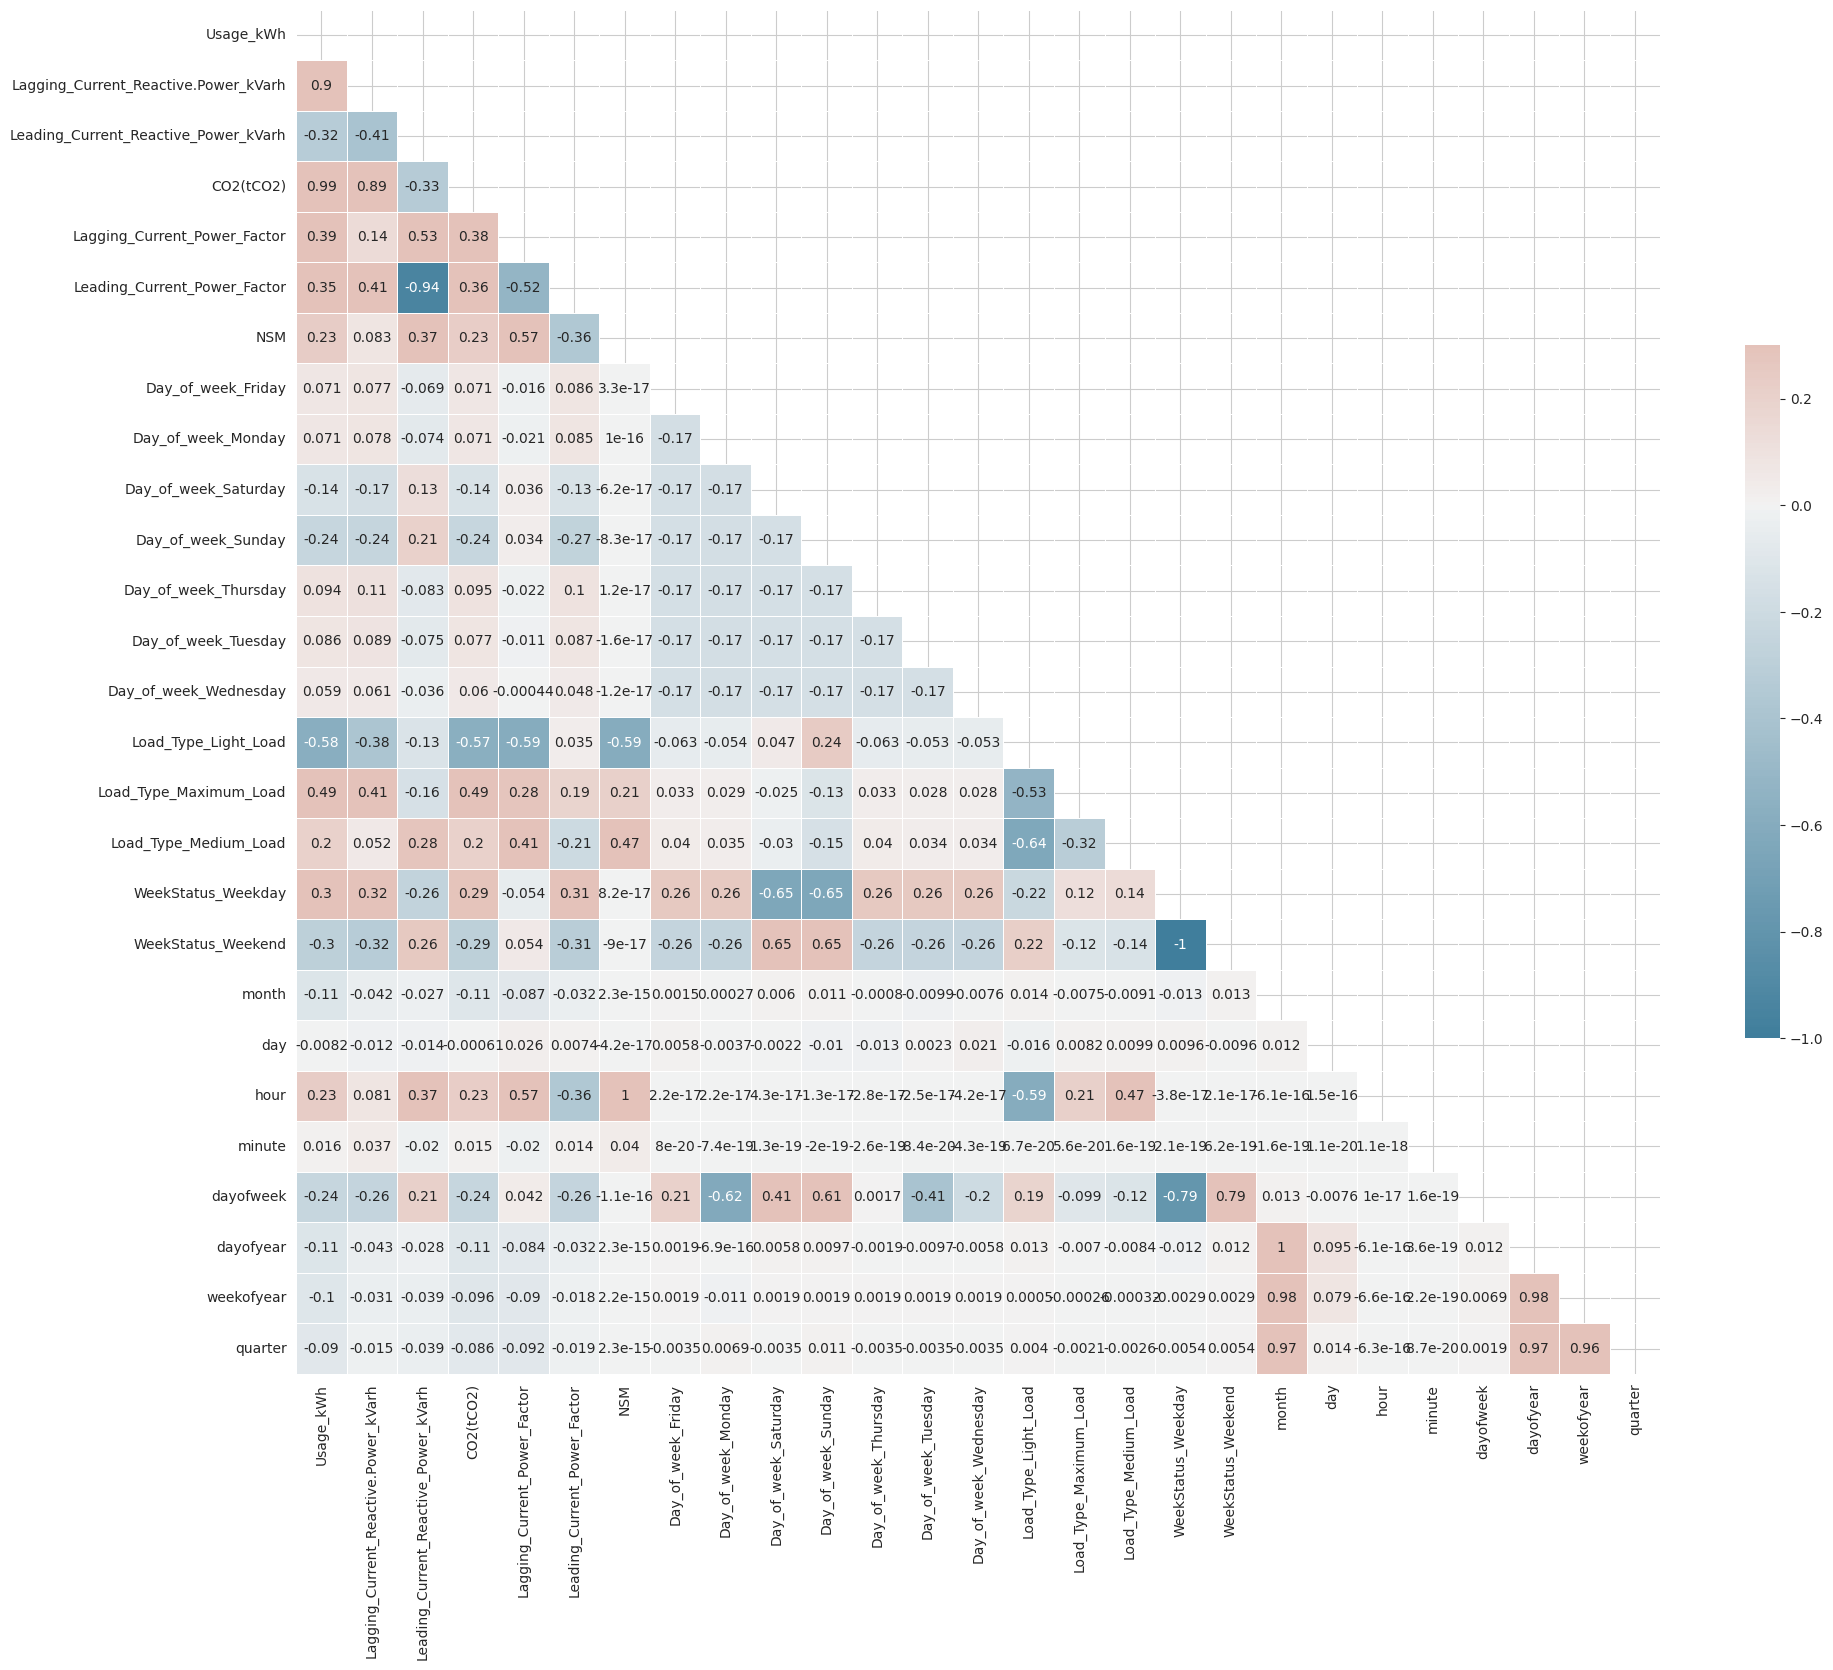

In [15]:
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(22, 18))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, annot=True, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [16]:
y = df['Usage_kWh']
X = df.drop(['Usage_kWh'], axis=1)

In [17]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_ = pd.DataFrame(X_scaled, columns=X.columns) 

In [18]:
# X_scaled_.sample(n=5)
# X_scaled_.var()
# data = DataFeaturesImportances(X, y)
# df_features_importances = data.get_feature_importance_matrix()

In [19]:
dataset_filename = Path('./steel_industry_energy_consumption_features_importances.parquet')

if dataset_filename.exists():
    df_features_importances = pd.read_parquet(dataset_filename)
else:
    data = DataFeaturesImportances(X_scaled_, y)
    df_features_importances = data.get_feature_importance_matrix()
    df_features_importances.to_parquet('steel_industry_energy_consumption_features_importances.parquet')

In [20]:
df_features_importances

,Feature,Random Forest,RF Permutation,Lasso,XGBoost
0,Lagging_Current_Reactive.Power_kVarh,0.015493,1.039679e+00,5.437309,0.010643
1,Leading_Current_Reactive_Power_kVarh,0.000325,1.317351e-03,0.177398,0.001066
2,CO2(tCO2),0.975624,9.836288e-01,26.345438,0.967615
3,Lagging_Current_Power_Factor,0.004738,3.199109e-02,2.265647,0.002394
4,Leading_Current_Power_Factor,0.001226,5.052287e-03,1.520283,0.005002
5,NSM,0.001013,4.752162e-03,0.298697,0.002298
6,Day_of_week_Friday,0.000011,1.240821e-06,-0.001742,0.000082
7,Day_of_week_Monday,0.000009,3.549408e-07,-0.008143,0.000236
8,Day_of_week_Saturday,0.000008,3.153501e-06,-0.062422,0.000127
9,Day_of_week_Sunday,0.000004,2.343802e-06,0.033222,0.000093


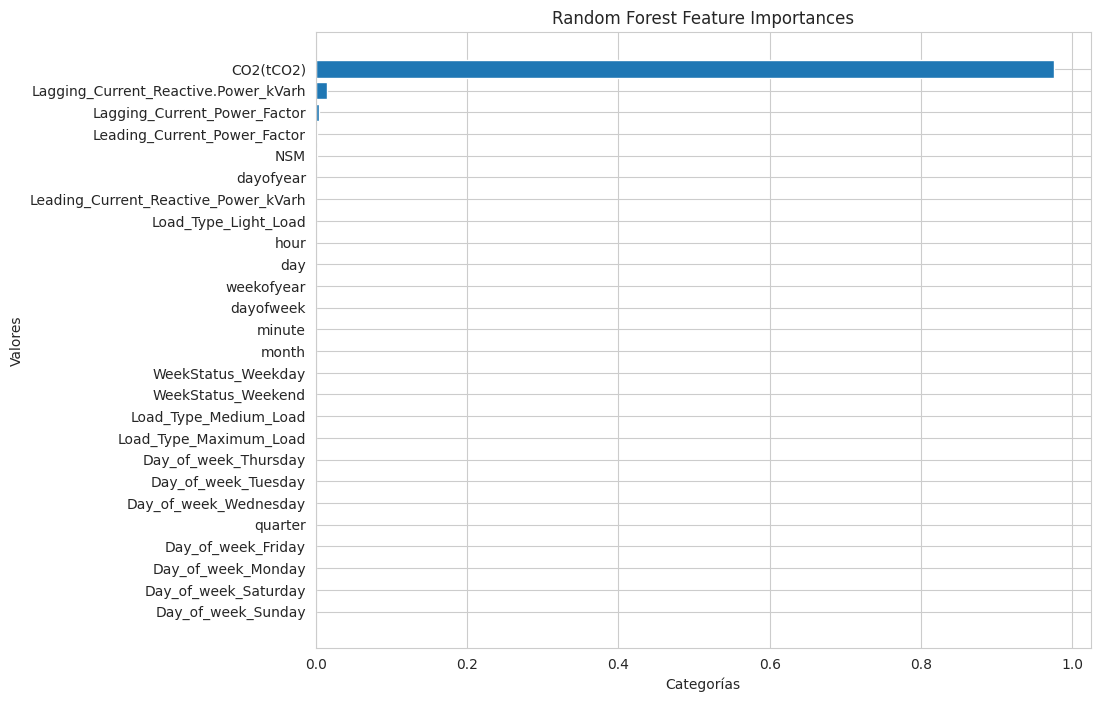

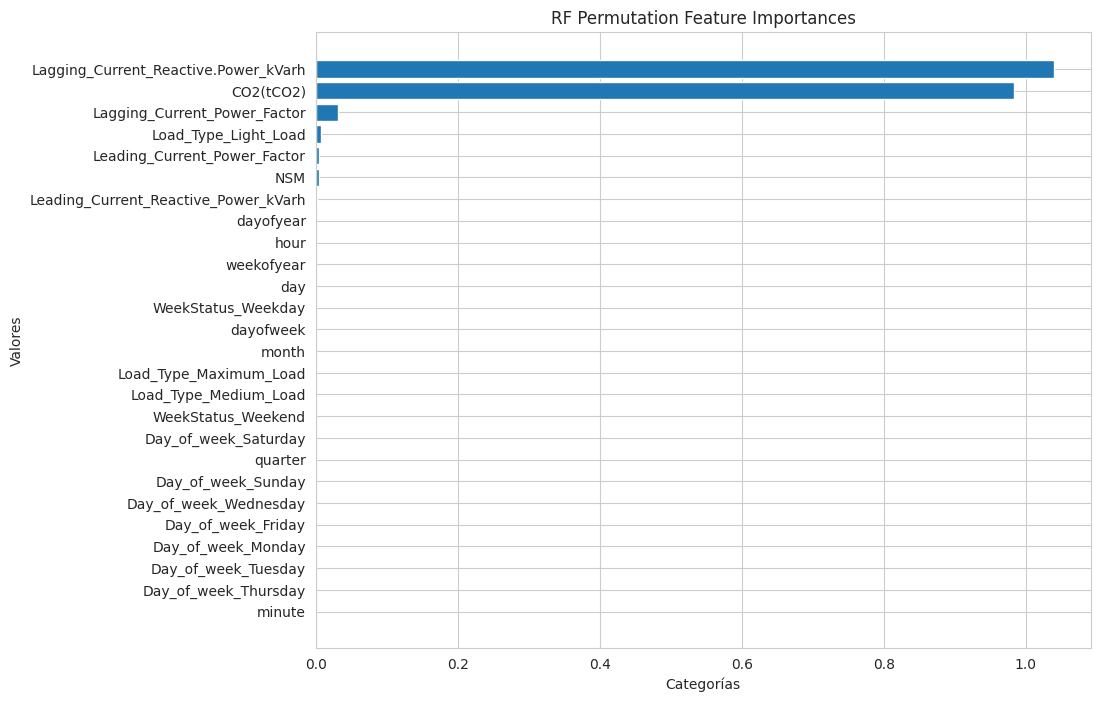

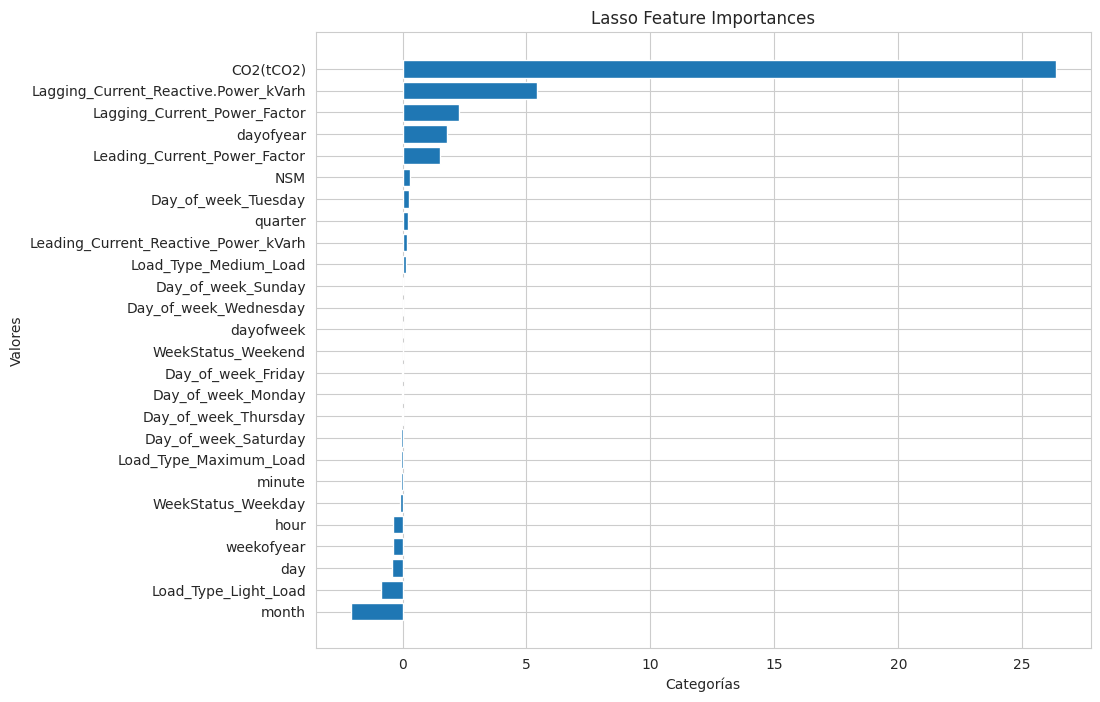

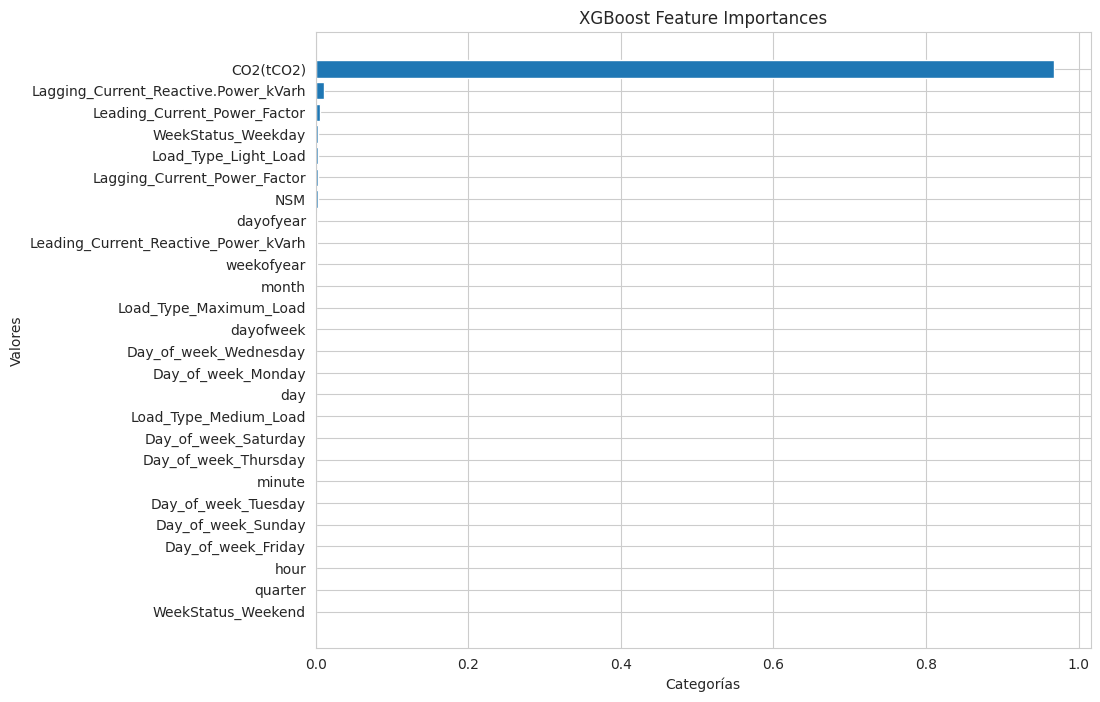

In [21]:
for feature_model in df_features_importances.columns[1:]:
    df_features_importances.sort_values(by=[feature_model], ascending=True, inplace=True)
    
    plt.figure(figsize=(10, 8))
    plt.barh(df_features_importances['Feature'], df_features_importances[feature_model])
    # Títulos y etiquetas
    plt.title(f"{feature_model} Feature Importances")
    plt.xlabel("Categorías")
    plt.ylabel("Valores")
    
    # plt.xlim(0, 0.02)  # Para visualizar los más pequeños
    #plt.ylim(0, 1) # Para visualizar los más pequeños
    # Inclinar texto en el eje X
    plt.xticks(rotation=0)

    # Mostrar gráfico
    plt.show()

In [22]:
# dataset_filename = Path('./steel_industry_energy_consumption_features_importances.parquet')
# if dataset_filename.exists():
#     df_features_importances = pd.read_parquet(dataset_filename)
# else:
#     data = DataFeaturesImportances(X, y)
#     df_features_importances = data.get_feature_importance_matrix()
#     #df_features_importances.to_parquet('steel_industry_energy_consumption_features_importances.parquet')
# dataset_filename = Path('./steel_industry_energy_consumption_features_importances.parquet')
# if dataset_filename.exists():
#     df_features_importances = pd.read_parquet(dataset_filename)
# else:
#     data = DataFeaturesImportances(X_scaled_, y)
#     df_features_importances = data.get_feature_importance_matrix()
#     #df_features_importances.to_parquet('steel_industry_energy_consumption_features_importances.parquet')
# df_features_importances.sort_values(by=['XGBoost'], ascending=False)
# df_features_importances[["Feature","RF Permutation"]]
# df_features_importances
# plt.figure(figsize=(20, 6))
# plt.bar(df_features_importances['Feature'], df_features_importances['Random Forest'])
# # Títulos y etiquetas
# plt.title("Random Forest Feature Importances")
# plt.xlabel("Categorías")
# plt.ylabel("Valores")
# 
# plt.ylim(0, 1) # Para visualizar los más pequeños
# # Inclinar texto en el eje X
# plt.xticks(rotation=90)
# 
# # Mostrar gráfico
# plt.show()
# 
# 
# plt.figure(figsize=(20, 6))
# plt.bar(df_features_importances['Feature'], df_features_importances['Random Forest'])
# # Títulos y etiquetas
# plt.title("Random Forest Feature Importances")
# plt.xlabel("Categorías")
# plt.ylabel("Valores")
# 
# plt.ylim(0, 0.05) # Para visualizar los más pequeños
# # Inclinar texto en el eje X
# plt.xticks(rotation=90)
# 
# # Mostrar gráfico
# plt.show()
# df_features_importances['Random Forest'][2:]
# df_features_importances.sort_values(by=['Random Forest'], ascending=False, inplace=True)
# # Configuración de la gráfica
# plt.figure(figsize=(10, 6))
# 
# # Iterar sobre las columnas excepto 'Feature'
# for column in df_features_importances[['Lasso']].columns[1:]:
#     plt.plot(df_features_importances['Feature'], df_features_importances[column], marker='o', label=column)
# 
# # Configuración del gráfico
# plt.title('Comparación de Importancias de Características')
# plt.xlabel('Características')
# plt.ylabel('Importancia')
# plt.xticks(rotation=45, ha='right')
# 
# # Ajustar el alcance del eje y y los ticks
# #plt.ylim(-1, 2)
# #plt.yticks(np.arange(-1, 1, 0.5))
# 
# plt.legend()
# plt.tight_layout()
# 
# # Mostrar el gráfico
# plt.show()
# # Configuración de la gráfica
# plt.figure(figsize=(10, 6))
# 
# # Iterar sobre las columnas excepto 'Feature'
# for column in df_features_importances[['Random Forest', 'RF Permutation','XGBoost']].columns[1:]:
#     plt.plot(df_features_importances['Feature'], df_features_importances[column], marker='o', label=column)
# 
# # Configuración del gráfico
# plt.title('Comparación de Importancias de Características')
# plt.xlabel('Características')
# plt.ylabel('Importancia')
# plt.xticks(rotation=45, ha='right')
# 
# # Ajustar el alcance del eje y y los ticks
# #plt.ylim(-1, 2)
# #plt.yticks(np.arange(-1, 1, 0.5))
# 
# plt.legend()
# plt.tight_layout()
# 
# # Mostrar el gráfico
# plt.show()
# # Configuración de la gráfica
# plt.figure(figsize=(20, 6))
# 
# # Iterar sobre las columnas excepto 'Feature'
# for column in df_features_importances[['Random Forest', 'RF Permutation','XGBoost']].columns[1:]:
#     plt.plot(df_features_importances['Feature'], df_features_importances[column], marker='o', label=column)
# 
# # Configuración del gráfico
# plt.title('Comparación de Importancias de Características')
# plt.xlabel('Características')
# plt.ylabel('Importancia')
# plt.xticks(rotation=45, ha='right')
# 
# # Ajustar el alcance del eje y y los ticks
# #plt.ylim(-1, 2)
# #plt.yticks(np.arange(-1, 1, 0.5))
# 
# plt.legend()
# plt.tight_layout()
# 
# # Mostrar el gráfico
# plt.show()

## Veamos como aporta los campos que creamos a partir de "date"

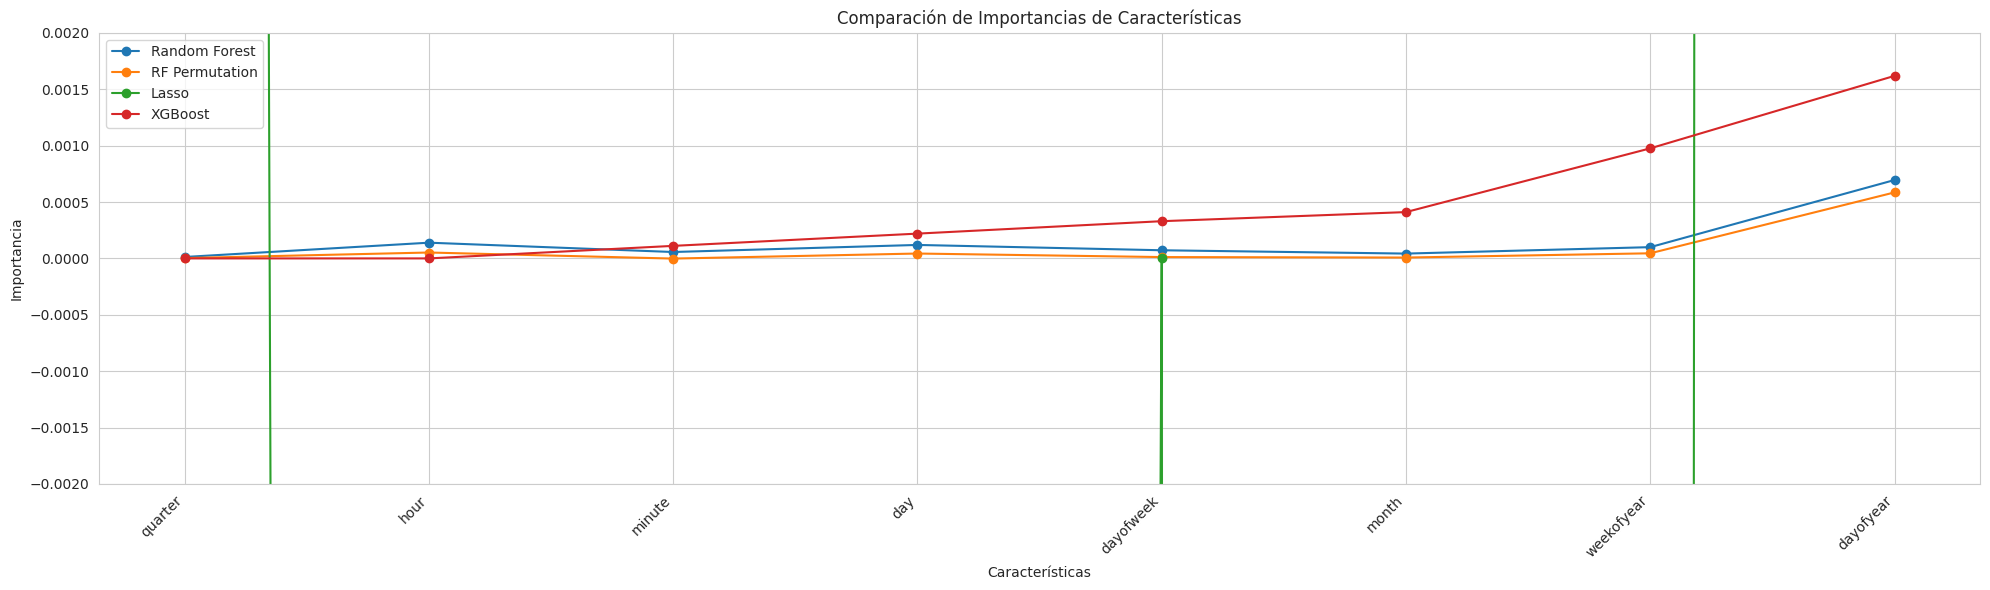

In [23]:
df_filtered = df_features_importances[df_features_importances['Feature'].isin(['month', 'day', 'hour', 'minute', 'dayofweek', 'dayofyear', 'weekofyear', 'quarter'])]

# Configuración de la gráfica
plt.figure(figsize=(20, 6))

# Iterar sobre las columnas excepto 'Feature'
for column in df_filtered.columns[1:]:
    plt.plot(df_filtered['Feature'], df_filtered[column], marker='o', label=column)

# Configuración del gráfico
plt.title('Comparación de Importancias de Características')
plt.xlabel('Características')
plt.ylabel('Importancia')
plt.xticks(rotation=45, ha='right')

# Ajustar el alcance del eje y y los ticks
plt.ylim(-0.002, 0.002)
#plt.yticks(np.arange(-0.01, 0.004, 0.00025))

plt.legend()
plt.tight_layout()

# Mostrar el gráfico
plt.show()

## Veamos como aportan los campos del dataset

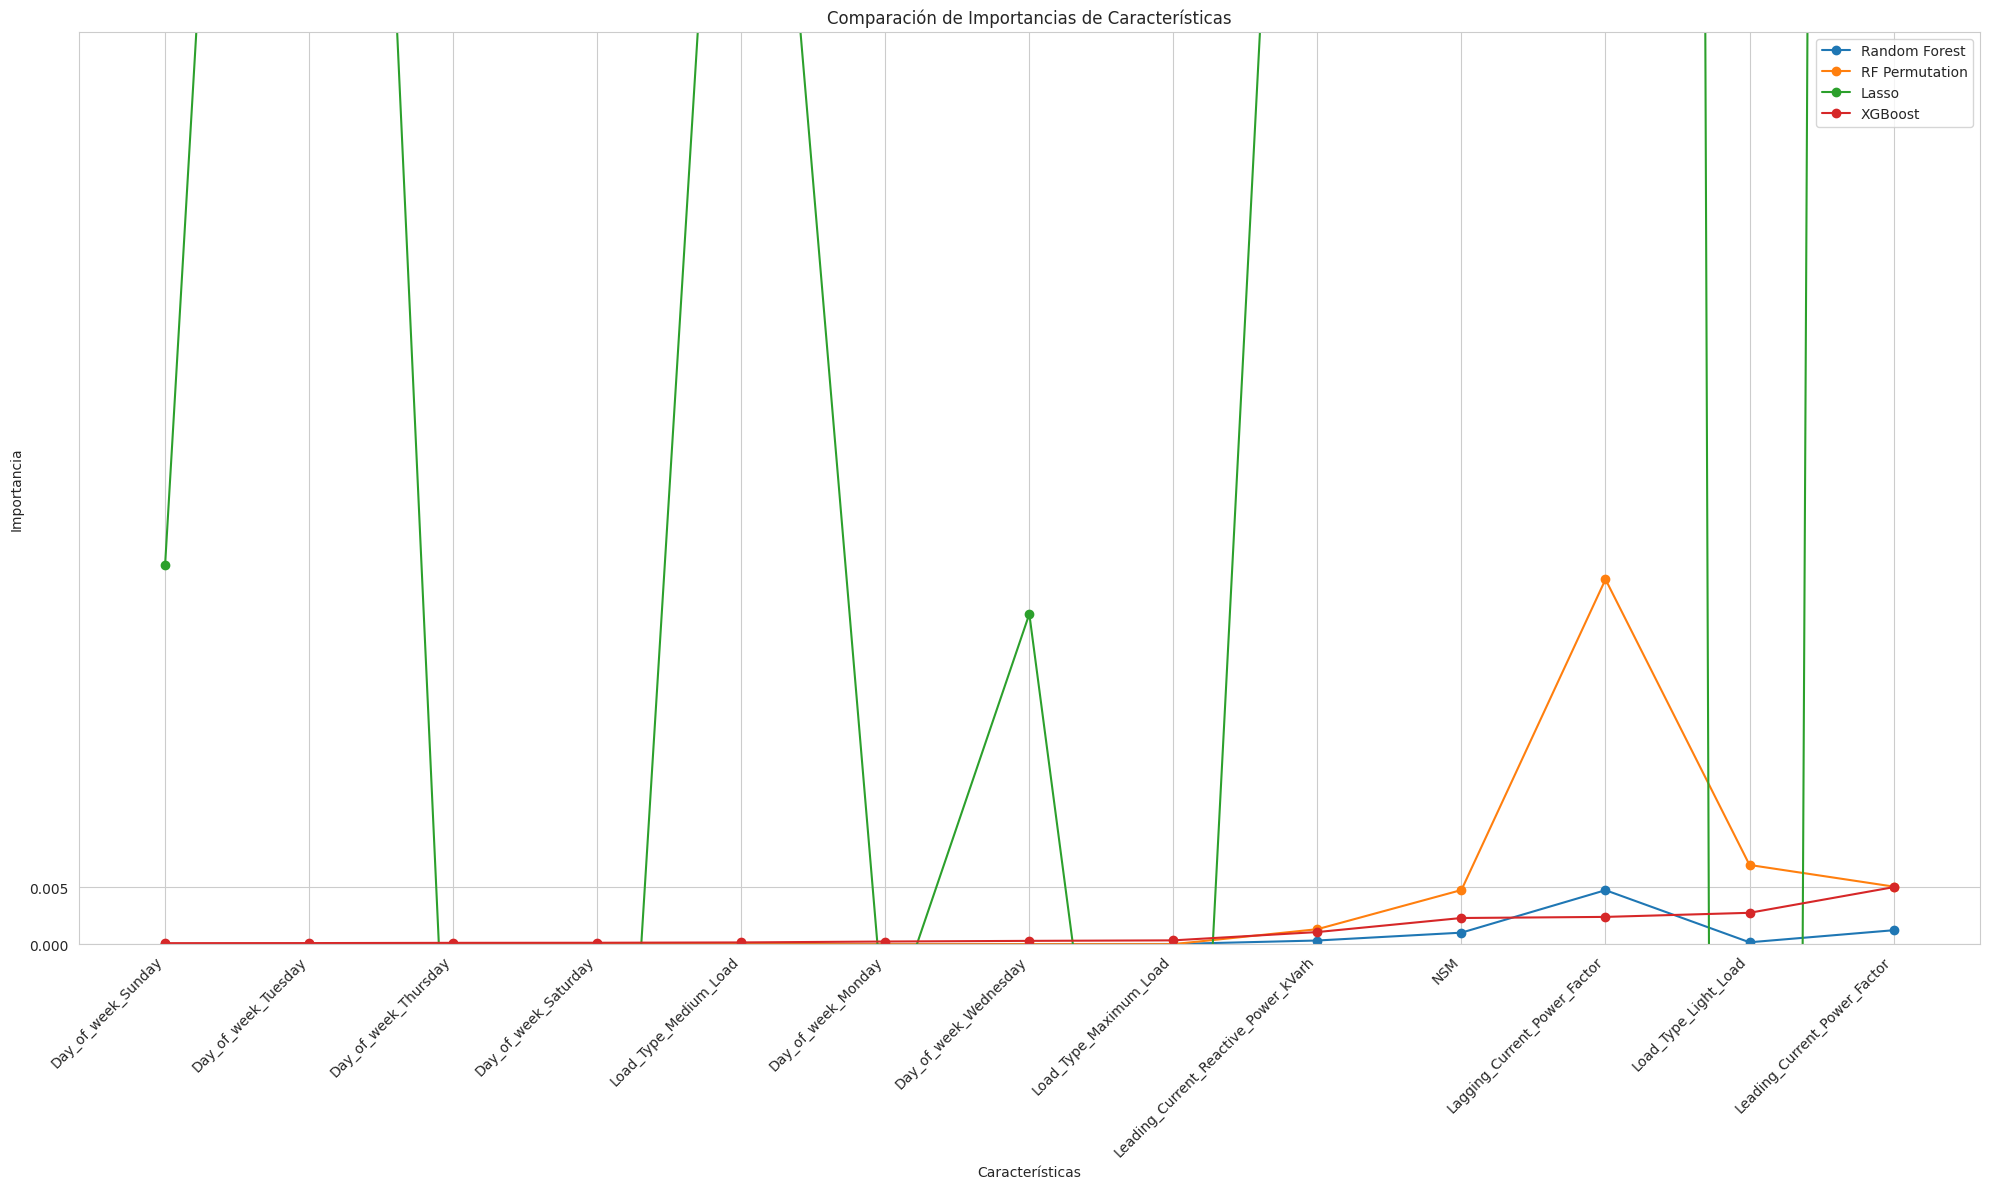

In [24]:
df_filtered = df_features_importances[df_features_importances['Feature'].isin( ['Leading_Current_Reactive_Power_kVarh', 'Lagging_Current_Power_Factor', 'Leading_Current_Power_Factor', 'NSM', 'IsWeekend', 'Day_of_week_Monday', 'Day_of_week_Saturday', 'Day_of_week_Sunday', 'Day_of_week_Thursday', 'Day_of_week_Tuesday', 'Day_of_week_Wednesday','Day_of_week_Monday', 'Load_Type_Maximum_Load','Load_Type_Medium_Load', 'Load_Type_Light_Load'])]

# Configuración de la gráfica
plt.figure(figsize=(20, 12))

# Iterar sobre las columnas excepto 'Feature'
for column in df_filtered.columns[1:]:
    plt.plot(df_filtered['Feature'], df_filtered[column], marker='o', label=column)

# Configuración del gráfico
plt.title('Comparación de Importancias de Características')
plt.xlabel('Características')
plt.ylabel('Importancia')
plt.xticks(rotation=45, ha='right')

# Ajustar el alcance del eje y y los ticks
plt.ylim(0, 0.08)
plt.yticks(np.arange(0, 0.01, 0.005))

plt.legend()
plt.tight_layout()

# Mostrar el gráfico
plt.show()

## Del gráfico anterior enfocamos los que son pequeños

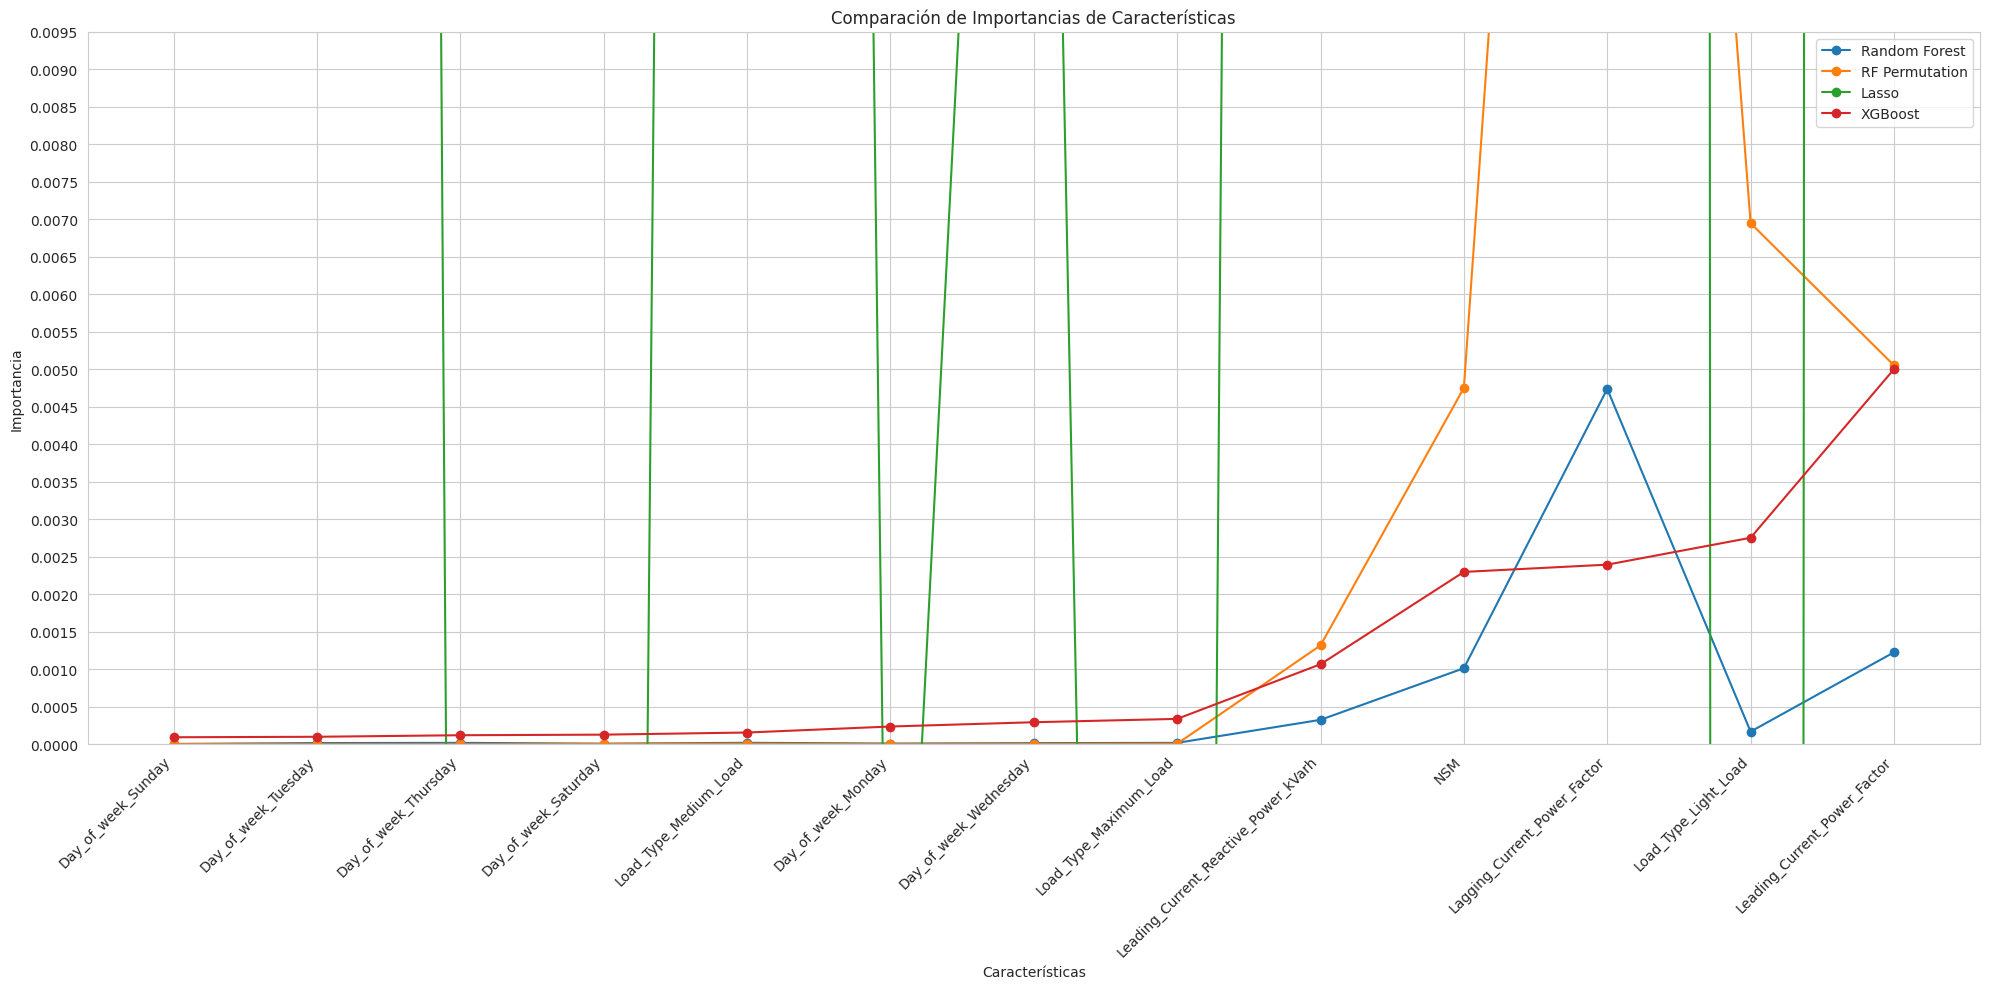

In [25]:
df_filtered = df_features_importances[df_features_importances['Feature'].isin( ['Leading_Current_Reactive_Power_kVarh', 'Lagging_Current_Power_Factor', 'Leading_Current_Power_Factor', 'NSM', 'IsWeekend', 'Day_of_week_Monday', 'Day_of_week_Saturday', 'Day_of_week_Sunday', 'Day_of_week_Thursday', 'Day_of_week_Tuesday', 'Day_of_week_Wednesday', 'Day_of_week_Monday', 'Load_Type_Maximum_Load', 'Load_Type_Medium_Load', 'Load_Type_Light_Load'])]

# Configuración de la gráfica
plt.figure(figsize=(20, 10))

# Iterar sobre las columnas excepto 'Feature'
for column in df_filtered.columns[1:]:
    plt.plot(df_filtered['Feature'], df_filtered[column], marker='o', label=column)

# Configuración del gráfico
plt.title('Comparación de Importancias de Características')
plt.xlabel('Características')
plt.ylabel('Importancia')
plt.xticks(rotation=45, ha='right')

# Ajustar el alcance del eje y y los ticks
plt.ylim(0, 0.005)
plt.yticks(np.arange(0, 0.01, 0.0005))

plt.legend()
plt.tight_layout()

# Mostrar el gráfico
plt.show()

## La data generada a partir de "date" no aporta a la variable objetivo, como se visualizó en el EDA, y ahora como se visualiza en el análisis de Feature Importances, por lo tanto será eliminada y no será parte del análisis.  

### Ver resultados BORUTA en: "Efficient energy consumption prediction model for a data analytic-enabled industry building in a smart city"

V E, S., Shin, C., & Cho, Y. (2020). Efficient energy consumption prediction model for a data analytic-enabled industry building in a smart city. Building Research & Information, 49(1), 127–143. https://doi.org/10.1080/09613218.2020.1809983


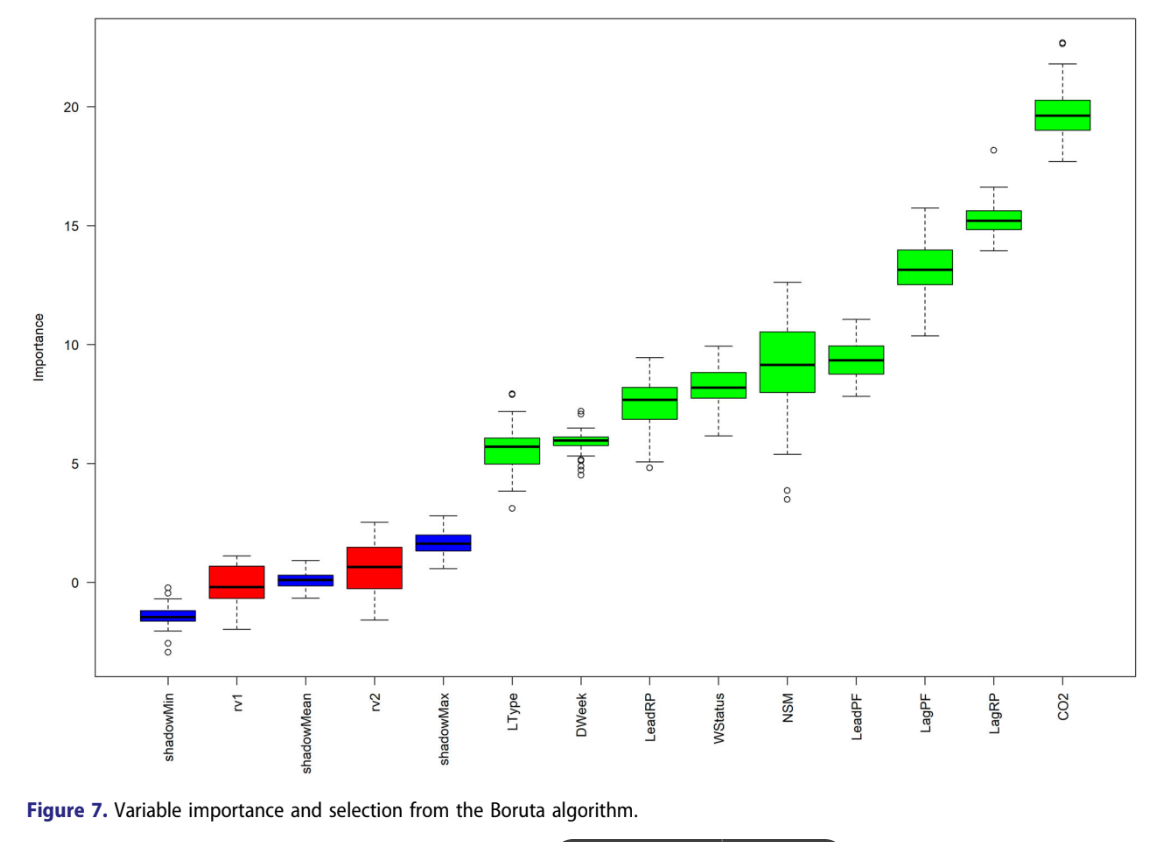

In [26]:
from IPython.display import Image, display

# Especificar la ruta de la imagen
image_path = 'referencia-boruta.png'

# Cargar y mostrar la imagen
display(Image(filename=image_path))


In [27]:
df = pd.read_csv('Steel_industry_data.csv')

In [28]:
df.drop(["date"], axis=1, inplace=True)
df = pd.get_dummies(df, columns=["Day_of_week", "Load_Type", "WeekStatus"], drop_first=False)

In [29]:
df.columns.to_list()

['Usage_kWh',
 'Lagging_Current_Reactive.Power_kVarh',
 'Leading_Current_Reactive_Power_kVarh',
 'CO2(tCO2)',
 'Lagging_Current_Power_Factor',
 'Leading_Current_Power_Factor',
 'NSM',
 'Day_of_week_Friday',
 'Day_of_week_Monday',
 'Day_of_week_Saturday',
 'Day_of_week_Sunday',
 'Day_of_week_Thursday',
 'Day_of_week_Tuesday',
 'Day_of_week_Wednesday',
 'Load_Type_Light_Load',
 'Load_Type_Maximum_Load',
 'Load_Type_Medium_Load',
 'WeekStatus_Weekday',
 'WeekStatus_Weekend']

In [30]:
df.to_parquet('steel-dataset.parquet')